# Modeling Topics and Predicting Ratings from Google Play Store Reviews

# Context & Dataset

## Source of Data: Google Play Store

Google Play Store, operated and developed by Google, serves as the official app store for certified Android devices. With over 82 billion app downloads and more than 3.5 million published apps, it stands as the largest app store globally. The platform allows users to browse and download applications developed with the Android software development kit (SDK).
Dataset

The dataset comprises over 12,000 reviews from real users for various applications available on the Google Play Store. Each review is accompanied by a rating, enabling classification into positive or negative sentiments.

The dataset is sourced from Kaggle: https://www.kaggle.com/datasets/prakharrathi25/google-play-store-reviews

# Problem Statement

User reviews provide valuable feedback for application development teams. However, analyzing these reviews can be challenging due to their unstructured nature and the vast volume of feedback received.

# Objectives

The project aims to achieve the following two main objectives:

-  **Generate Topic Models**: Develop a series of topic models to identify the most common topics mentioned in the reviews. By doing so, developers can quickly understand what users are discussing the most, enabling them to make appropriate changes to the applications based on user feedback.

-  **Build Rating Prediction Model**: Create a predictive model that can determine the rating of a review based on its text. This will enable developers to gauge the overall sentiment of the reviews and make necessary adjustments to the applications accordingly.

By accomplishing these objectives, developers can gain valuable insights from user reviews, aiding in enhancing their applications and improving user satisfaction.

# Data Cleaning

Some minor data cleaning was performed on the dataset to prepare it for analysis. The following steps were taken:

In [5]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('reviews.csv')

In [6]:
# Ignore errors
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Fill in the missing data
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].fillna('Unknown')

# Drop the unnecessary columns
df = df.drop(['userImage', 'sortOrder'], axis=1)

# Topic Modeling

A series of different topic modeling techniques will be applied to the reviews content: Latent Semantic Indexing, Latent Dirichlet Allocation, and Latent Dirichlet with Spacy named entity recognition.

Before that we will perform some data cleaning and preprocessing on the reviews text, including tokenization, lemmatization, and stop word removal. Also, a dictionary and corpus will be created to feed into the topic models.

In [8]:
# Import necessary libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import TfidfModel, LsiModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.callbacks import PerplexityMetric


# Define stop words and lemmatizer
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Define text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Remove stop words and words with length < 3
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

# Apply text preprocessing to review content
df['content_clean'] = df['content'].apply(preprocess_text)

In [6]:
# Topic modeling using LSI from gensim
from gensim import corpora, models, similarities

# Tokenize documents
texts = [doc.split() for doc in df['content_clean']]

# Create dictionary and corpus
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

## Topic Modeling using Latent Semantic Indexing Model

Latent Semantic Indexing (LSI) is a statistical model that analyzes relationships between a set of documents and the terms they contain by producing a set of concepts related to the documents and terms. It is a technique used in natural language processing and information retrieval to identify patterns in the relationships between the terms and concepts contained in a set of documents. LSI is often used for tasks such as document classification, clustering, and information retrieval.

In [7]:
# Build LSI model
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lsi_model = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)

In [8]:
# Get the coherence & perplexity scores for the SVD model
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Calculate coherence score
coherence_model = CoherenceModel(model=lsi_model, texts=texts, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print("Coherence score:", coherence_score)

Coherence score: 0.4777840022774105


In [9]:
# Optimize the number of topics using coherence score as the metric

# Tokenize documents
documents = [doc.split() for doc in df['content_clean']]

# Create a dictionary from the preprocessed documents
id2word = Dictionary(documents)

# Create a corpus from the preprocessed documents
corpus = [id2word.doc2bow(doc) for doc in documents]

# Build multiple LSI models with varying numbers of topics
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics + step_size, step_size)

lsi_models = []
for num_topics in topics_range:
    lsi_model = LsiModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
    lsi_models.append(lsi_model)

# Calculate the coherence score for each LSI model
coherence_scores = []
for model in lsi_models:
    coherence_model = CoherenceModel(model=model, texts=documents, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Select the model with the highest coherence score
optimal_model = lsi_models[coherence_scores.index(max(coherence_scores))]
num_topics = topics_range[coherence_scores.index(max(coherence_scores))]

print('Optimal number of topics:', num_topics)
print('Coherence score:', max(coherence_scores))

Optimal number of topics: 3
Coherence score: 0.5502008651108544


In [11]:
# Rebuild the LSI model with the optimal number of topics
lsi_model = LsiModel(corpus=corpus, id2word=id2word, num_topics=num_topics)

In [13]:
# Get the top words for each topic
topics = optimal_model.show_topics(num_topics=num_topics, num_words=10)

# Print out the top words for each topic
for topic in topics:
    print('Topic', topic[0])
    print(topic[1])


Topic 0
0.701*"app" + 0.300*"n't" + 0.232*"task" + 0.154*"time" + 0.138*"like" + 0.120*"would" + 0.112*"day" + 0.111*"use" + 0.102*"calendar" + 0.098*"list"
Topic 1
0.612*"task" + -0.593*"app" + 0.311*"n't" + 0.158*"day" + 0.145*"list" + 0.133*"time" + 0.094*"like" + 0.084*"one" + 0.075*"would" + 0.075*"option"
Topic 2
-0.725*"n't" + 0.569*"task" + 0.211*"app" + -0.132*"calendar" + -0.108*"work" + 0.092*"list" + -0.066*"version" + -0.061*"event" + -0.056*"get" + -0.050*"phone"


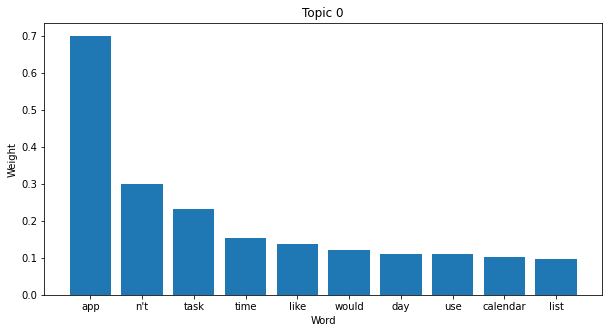

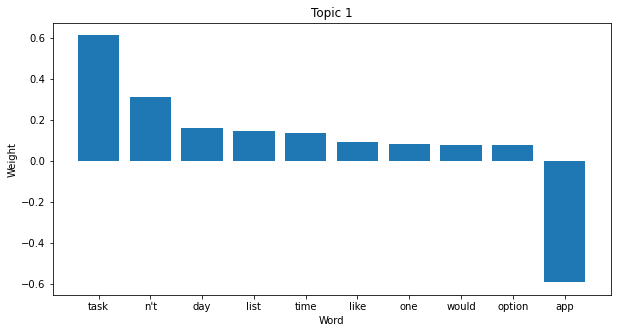

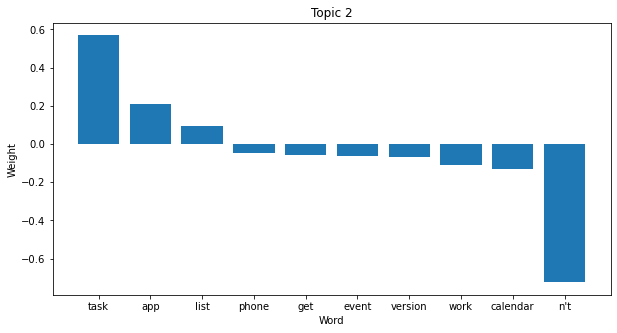

In [15]:
# Plot the topics
import matplotlib.pyplot as plt

# Set the number of topics and the number of top words to show
num_topics = 3
num_top_words = 10

# Plot a bar chart for each topic
for i in range(num_topics):
    # Get the top words and their weights for this topic
    top_words = lsi_model.show_topic(i, topn=num_top_words)
    top_words = sorted(top_words, key=lambda x: x[1], reverse=True)
    
    # Extract the words and their weights as separate lists
    words = [word for word, weight in top_words]
    weights = [weight for word, weight in top_words]
    
    # Plot the bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(words, weights)
    plt.title(f"Topic {i}")
    plt.xlabel("Word")
    plt.ylabel("Weight")
    plt.show();

# Topic Modeling using Latent Dirichlet Allocation Model

Latent Dirichlet Allocation (LDA) is a generative statistical model used for topic modeling. It assumes that each document in a corpus is a mixture of topics, and each topic is a probability distribution over words. LDA uses Bayesian inference to identify the topics that best explain the words in a corpus. It is a widely used technique in natural language processing and information retrieval for tasks such as document classification, clustering, and information retrieval.

In [18]:
# Topic modeling using LDA from gensim
from gensim import corpora, models, similarities

# Tokenize documents
texts = [doc.split() for doc in df['content_clean']]

# Create dictionary and corpus
dictionary = Dictionary(texts)

# Create a corpus from the preprocessed documents
corpus = [dictionary.doc2bow(text) for text in texts]

# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=2)

# Get the coherence & perplexity scores for the LDA model
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Calculate coherence score
coherence_model = CoherenceModel(model=lda_model, texts=texts, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print("Coherence score:", coherence_score)

Coherence score: 0.40960528947359176


In [19]:
# Optimize the number of topics using coherence score as the metric

# Build multiple LDA models with varying numbers of topics
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics + step_size, step_size)

lda_models = []
for num_topics in topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
    lda_models.append(lda_model)

# Calculate the coherence score for each LSI model
coherence_scores = []
for model in lda_models:
    coherence_model = CoherenceModel(model=model, texts=documents, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Select the model with the highest coherence score
optimal_model = lda_models[coherence_scores.index(max(coherence_scores))]
num_topics = topics_range[coherence_scores.index(max(coherence_scores))]

print('Optimal number of topics:', num_topics)
print('Coherence score:', max(coherence_scores))

Optimal number of topics: 13
Coherence score: 0.5191168755799782


In [21]:
# Rebuild the LDA model with the optimal number of topics
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)

In [22]:
# Get the top words for each topic
topics = optimal_model.show_topics(num_topics=num_topics, num_words=10)

# Print out the top words for each topic
for topic in topics:
    print('Topic', topic[0])
    print(topic[1])


Topic 0
0.049*"app" + 0.029*"ad" + 0.015*"n't" + 0.014*"phone" + 0.011*"update" + 0.010*"task" + 0.009*"day" + 0.009*"event" + 0.009*"appointment" + 0.008*"new"
Topic 1
0.028*"task" + 0.024*"app" + 0.020*"n't" + 0.020*"time" + 0.017*"widget" + 0.015*"show" + 0.012*"list" + 0.010*"day" + 0.010*"option" + 0.009*"would"
Topic 2
0.068*"app" + 0.048*"love" + 0.040*"great" + 0.029*"easy" + 0.029*"use" + 0.018*"helpful" + 0.017*"really" + 0.017*"useful" + 0.016*"planner" + 0.015*"widget"
Topic 3
0.027*"n't" + 0.023*"event" + 0.020*"work" + 0.019*"task" + 0.018*"sync" + 0.016*"app" + 0.014*"like" + 0.013*"list" + 0.013*"account" + 0.012*"one"
Topic 4
0.028*"great" + 0.023*"app" + 0.019*"free" + 0.018*"habit" + 0.013*"feature" + 0.012*"n't" + 0.010*"version" + 0.010*"list" + 0.009*"add" + 0.008*"premium"
Topic 5
0.041*"app" + 0.040*"n't" + 0.018*"work" + 0.015*"notification" + 0.013*"use" + 0.012*"like" + 0.012*"version" + 0.010*"time" + 0.009*"calendar" + 0.009*"get"
Topic 6
0.016*"n't" + 0.01

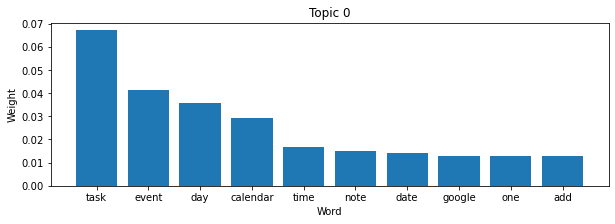

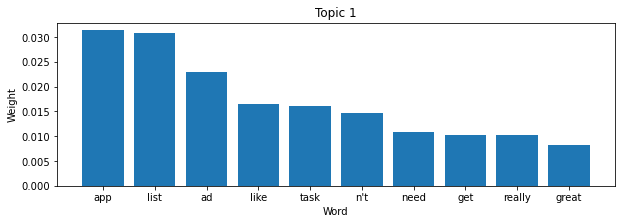

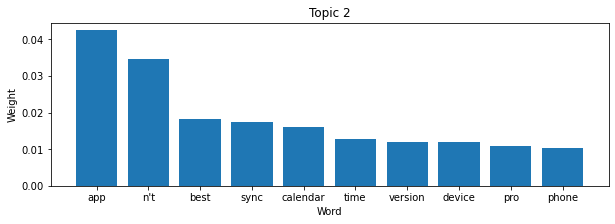

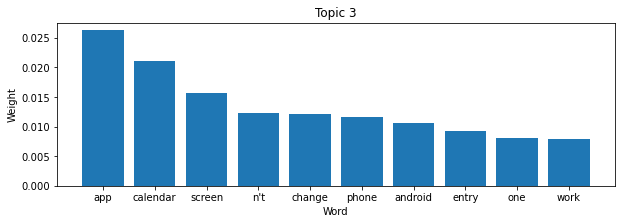

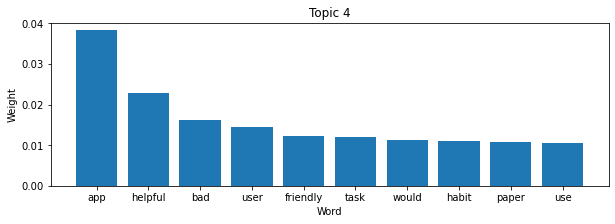

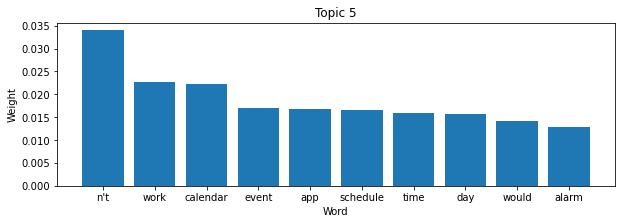

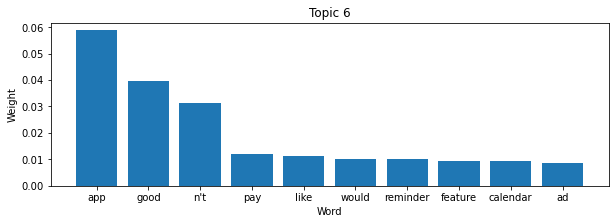

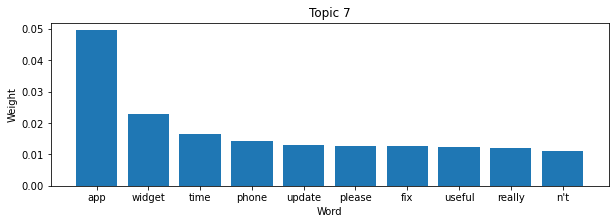

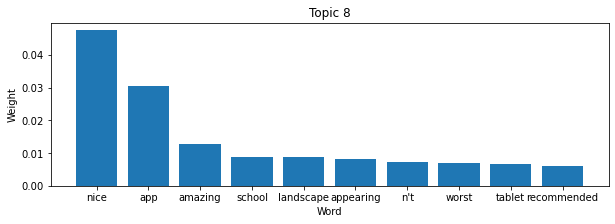

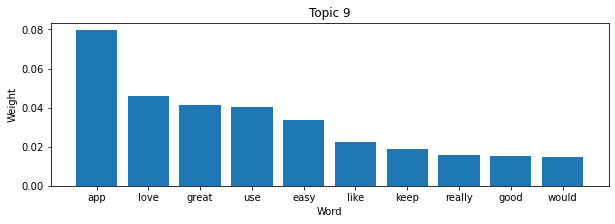

In [25]:
# Plot the topics
import matplotlib.pyplot as plt

# Set the number of topics and the number of top words to show
num_topics = 10
num_top_words = 10

# Plot a bar chart for each topic
for i in range(num_topics):
    # Get the top words and their weights for this topic
    top_words = lda_model.show_topic(i, topn=num_top_words)
    top_words = sorted(top_words, key=lambda x: x[1], reverse=True)
    
    # Extract the words and their weights as separate lists
    words = [word for word, weight in top_words]
    weights = [weight for word, weight in top_words]
    
    # Plot the bar chart
    plt.figure(figsize=(10, 3))
    plt.bar(words, weights)
    plt.title(f"Topic {i}")
    plt.xlabel("Word")
    plt.ylabel("Weight")
    plt.show();

## LDA with Spacy - Topic Modeling

LDA with Spacy is a technique for topic modeling that uses the Spacy NLP library to preprocess text data and extract features such as part-of-speech tags, named entities, and dependency parse trees. The preprocessed data is then used as input to the LDA algorithm to identify the topics that best explain the words in a corpus. This technique combines the strengths of Spacy for natural language processing and LDA for topic modeling to provide a powerful tool for analyzing large volumes of text data.

In [49]:
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm

In [50]:
# Load the small English NLP model
nlp = en_core_web_sm.load()

# Create a list of stop words to filter out
stop_words = list(STOP_WORDS)

# Define a function to remove stop words, punctuation, and lemmatize the tokens
def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    return ' '.join(tokens)

In [54]:
# Apply the preprocessing function to the 'content_clean' column
df['processed_text'] = df['content_clean'].apply(preprocess)

# Create a list of documents to be used for topic modeling
documents = [[token.text for token in nlp(doc)] for doc in df["processed_text"]]

# Create a corpus from the list of documents
corpus = []
for doc in documents:
    corpus.append(nlp(" ".join(doc)))

# Define the number of topics to identify
num_topics = 3

In [55]:
# Run LDA topic modeling on the corpus
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Create a Gensim dictionary from the corpus
dictionary = Dictionary(documents)

# Create a bag-of-words representation of the corpus
corpus_bow = [dictionary.doc2bow(doc) for doc in documents]

# Train the LDA model on the bag-of-words corpus
lda_model = LdaModel(corpus_bow, num_topics=num_topics, id2word=dictionary, passes=10)

In [56]:
# Print the top 10 words for each topic
for i in range(num_topics):
    topic_words = [word[0] for word in lda_model.show_topic(i, topn=10)]
    print(f"Topic {i+1}: {', '.join(topic_words)}")

Topic 1: good, easy, use, help, love, nice, great, helpful, habit, useful
Topic 2: time, day, calendar, like, event, add, work, list, great, set
Topic 3: version, pay, sync, phone, calendar, pro, free, work, google, ad


In [57]:
# Get the coherence score
from gensim.models import CoherenceModel

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print(f"Coherence Score: {coherence_lda}")

Coherence Score: 0.4731619626757006


### Optimize the number of topics for the Spacy model

In [60]:
import gensim

In [61]:
# Define a range of possible number of topics
num_topics_range = range(2, 11)

# Create a list to store the coherence scores for each number of topics
coherence_scores = []

# Iterate over the range of number of topics
for num_topics in num_topics_range:
    # Create an LDA model with the current number of topics
    lda_model = gensim.models.LdaModel(corpus=corpus_bow,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=42)
    
    # Calculate the coherence score for the current model
    coherence_model = CoherenceModel(model=lda_model,
                                     texts=documents,
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    # Add the coherence score to the list
    coherence_scores.append(coherence_score)
    
# Find the number of topics with the highest coherence score
optimal_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]

print('Optimal number of topics:', optimal_num_topics)


Optimal number of topics: 10


In [68]:
# Print the coherence score for the model with optimal number
print('Coherence score:', max(coherence_scores))

Coherence score: 0.46858308450979164


In [64]:
# Print the top 10 words for each topic
for i in range(num_topics):
    topic_words = [word[0] for word in lda_model.show_topic(i, topn=10)]
    print(f"Topic {i+1}: {', '.join(topic_words)}")

Topic 1: nice, calendar, phone, like, planner, google, list, day, view, time
Topic 2: add, like, calendar, ad, good, use, planner, list, help, feature
Topic 3: calendar, widget, event, google, use, want, need, option, like, display
Topic 4: use, good, easy, planner, sync, work, calendar, love, help, time
Topic 5: pay, version, like, free, feature, premium, available, subscription, year, backup
Topic 6: good, user, repeat, far, friendly, recommend, time, great, love, habit
Topic 7: event, pro, version, time, great, calendar, day, like, ad, buy
Topic 8: reminder, set, time, notification, work, calender, day, list, thing, like
Topic 9: work, device, sync, phone, not, problem, password, fix, watch, use
Topic 10: great, love, day, useful, note, schedule, appointment, change, time, date


# BERT Application to Predict Review Score

BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained deep learning model for natural language processing (NLP) developed by Google. It is designed to understand the context of words in a sentence by training on a large corpus of text data. BERT is a transformer-based model that uses attention mechanisms to learn contextual relations between words in a text.

We will utilize BERT for predicting review scores. To achieve this, we will fine-tune the BERT model using a dataset of reviews along with their corresponding scores. Prior to feeding the reviews into the BERT model, we will preprocess them using techniques like tokenization and padding, ensuring they are in a suitable format for input. During the fine-tuning process, the model will be trained on the review dataset to comprehend the relationship between the text and the review scores. Once the training is complete, we can leverage the trained model to predict the scores of new reviews. By inputting the preprocessed text of these new reviews into the model, we will obtain the predicted scores as the output.

In [9]:
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appId,content_clean
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,com.anydo,open app anymore
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,I have been begging for a refund from this app...,1,0,Unknown,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,com.anydo,begging refund app month nobody replying
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,Very costly for the premium version (approx In...,1,0,Unknown,2020-10-27 08:18:40,NaN,NaN,com.anydo,costly premium version approx indian rupee 910...
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,"Used to keep me organized, but all the 2020 UP...",1,0,Unknown,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,com.anydo,used keep organized 2020 update made mess thin...
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,com.anydo,dan birthday oct


In [10]:
import transformers

In [11]:
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score

In [13]:
# Load the small English NLP model
nlp = en_core_web_sm.load()

# Create a list of stop words to filter out
stop_words = list(STOP_WORDS)

# Define a function to remove stop words, punctuation, and lemmatize the tokens
def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    return ' '.join(tokens)

# Apply the preprocessing function to the 'content_clean' column
df['processed_text'] = df['content_clean'].apply(preprocess)

In [14]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
# Set the maximum sequence length
max_length = 512

# Apply the tokenizer to the text
encoded_data = df['processed_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length)))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [16]:
# Find the maximum length of the encoded data
max([len(sentence) for sentence in encoded_data])

501

In [17]:
# Find the maximum length of the encoded data
max_len = 0
for i in encoded_data.values:
    if len(i) > max_len:
        max_len = len(i)

In [18]:
# Pad the encoded data
padded_data = np.array([i + [0]*(max_len-len(i)) for i in encoded_data.values])

In [19]:
# Create attention masks
attention_masks = np.where(padded_data != 0, 1, 0)

In [20]:
# Transform the df score into a label
df['label'] = df['score'].apply(lambda x: 1 if x > 3 else 0)

In [23]:
# Split the data into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(padded_data, df['label'],
                                                                                    random_state=42, test_size=0.2)


In [21]:
# Split the attention masks into training and validation sets
train_masks, validation_masks, _, _ = train_test_split(attention_masks, padded_data,
                                                random_state=42, test_size=0.2)

In [24]:
# Assuming train_labels is a pandas Series object
train_labels = train_labels.values
validation_labels = validation_labels.values

In [25]:
# Convert the data to torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [178]:
# Define the batch size
batch_size = 8

In [179]:
# Create the DataLoader for the training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [180]:
# Create the DataLoader for the validation set
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [29]:
# Load the BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",  
                                                        num_labels=2,
                                                        output_attentions=False,
                                                        output_hidden_states=False)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [181]:
model.to(torch.float16)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [182]:
# Tell pytorch to run this model on the GPU
model.cuda().half()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [183]:
# Get all of the model's parameters as a list of tuples
params = list(model.named_parameters())

In [184]:
# Print the model's parameters
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)
==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (7

In [185]:
# Get the optimizer
optimizer = AdamW(model.parameters(),
                    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [186]:
# Get the total number of training steps
total_steps = len(train_dataloader) * 3

In [187]:
import transformers
print(transformers.__version__)


4.14.1


In [188]:
from transformers import get_linear_schedule_with_warmup

In [189]:
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [190]:
# Define the function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [191]:
# Function to calculate the F1 score
def f1_score_func(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, average='weighted')

In [192]:
# Function to calculate the average loss over an epoch
def loss_fn(preds, labels):
    return torch.nn.CrossEntropyLoss()(preds, labels)

In [193]:
# Define time
import time

In [194]:
import torch

# Check if GPU is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [195]:
torch.cuda.empty_cache()

In [196]:
import datetime

def format_time(elapsed):
    """
    Takes a time in seconds and returns a string hh:mm:ss
    """
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [198]:
# Store the average loss after each epoch so we can plot them
loss_values = []

# For each epoch...
for epoch_i in range(0, 3):
                            
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.
        
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, 3))
        print('Training...')
        
        # Measure how long the training epoch takes.
        t0 = time.time()
        
        # Reset the total loss for this epoch.
        total_loss = 0
        
        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()
        
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        
    
            # Perform a forward pass (evaluate the model on this training batch).
            
            # This will return the loss (rather than the model output) because we
            # have provided the `labels`.
            
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
            # The call to `model` always returns a tuple, so we need to pull the
            # loss value out of the tuple.
            
            loss = outputs[0]

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value
            # from the tensor.

            total_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

                
            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                                        # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()
            
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_loss / len(train_dataloader)

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  1,250.    Elapsed: 0:00:17.
  Batch    80  of  1,250.    Elapsed: 0:00:34.
  Batch   120  of  1,250.    Elapsed: 0:00:52.
  Batch   160  of  1,250.    Elapsed: 0:01:10.
  Batch   200  of  1,250.    Elapsed: 0:01:27.
  Batch   240  of  1,250.    Elapsed: 0:01:43.
  Batch   280  of  1,250.    Elapsed: 0:02:04.
  Batch   320  of  1,250.    Elapsed: 0:02:24.
  Batch   360  of  1,250.    Elapsed: 0:02:39.
  Batch   400  of  1,250.    Elapsed: 0:02:54.
  Batch   440  of  1,250.    Elapsed: 0:03:08.
  Batch   480  of  1,250.    Elapsed: 0:03:31.
  Batch   520  of  1,250.    Elapsed: 0:03:47.
  Batch   560  of  1,250.    Elapsed: 0:04:02.
  Batch   600  of  1,250.    Elapsed: 0:04:21.
  Batch   640  of  1,250.    Elapsed: 0:04:37.
  Batch   680  of  1,250.    Elapsed: 0:04:54.
  Batch   720  of  1,250.    Elapsed: 0:05:11.
  Batch   760  of  1,250.    Elapsed: 0:05:26.
  Batch   800  of  1,250.    Elapsed: 0:05:40.
  Batch   840  of

In [204]:
# Store the average loss after each epoch so we can plot them
loss_values = []

# For each epoch...
for epoch_i in range(0, 3):
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # define num_labels
        num_labels = 2
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Calculate the loss for this batch of test sentences, and
        # accumulate the total test loss.
        loss = loss_fn(logits.view(-1, num_labels), b_labels.view(-1))
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


Running Validation...
  Accuracy: 0.55
  Validation Loss: nan
  Validation took: 0:00:39


In [ ]:
# Save the model to a file
output_dir = 'C:\Users\dario\OneDrive\Documents\GitHub\Resume'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

In [ ]:
# Load the model from the file
output_dir = 'C:\Users\dario\OneDrive\Documents\GitHub\Resume'
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU
model.cuda()

# Function to predict the sentiment of a sentence
def predict_sentiment(text):
    # Apply the tokenizer to the text
    encoded_text = tokenizer.encode_plus(
        text,
        max_length=max_length,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Get the model output
    output = model(encoded_text['input_ids'].to(device), encoded_text['attention_mask'].to(device))
    
    # Get the predicted class label
    _, prediction = torch.max(output[0], dim=1)
    
    # Return the label
    return prediction

In [ ]:
print(predict_sentiment("This app is great!"))

In [ ]:
print(predict_sentiment("This app is terrible!"))